# Imports

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

In [150]:
wego = pd.read_csv('../data/Headway Data, 8-1-2023 to 9-30-2023.csv')

In [151]:
wego.shape

(350329, 30)

In [152]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES'],
      dtype='object')

## create unique trip id

In [153]:
def create_id(row):
    row['CALENDAR_ID'] + ''

In [154]:
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [155]:
wego['DATE_TRIP'].nunique()

67370

### Create Headway Categories

In [156]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return abs(row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

In [157]:
# create headway deviation percentable column
wego.loc[:, 'HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [159]:
# Create Bunching or Gapping Indicator
def is_hdwy_bunching(dev, pct):
    if (dev < 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_gapping(dev, pct):
    if (dev > 0) & (pct > 50):
        return int(1)
    else:
        return int(0)
def is_hdwy_acceptable(pct):
    if pct <= 50:
        return int(1)
    else:
        return int(0)

In [164]:
# Create new Bunching/gapping columns with Boolean values for each group.
wego.loc[:, 'HDWY_BUNCHING'] = wego.apply(lambda r: 
                                          is_hdwy_bunching(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_ACCEPTABLE'] = wego.apply(lambda r: 
                                            is_hdwy_acceptable(r['HDWY_DEV_PCT']), axis=1)
wego.loc[:, 'HDWY_GAPPING'] = wego.apply(lambda r: 
                                         is_hdwy_gapping(r['HDWY_DEV'], r['HDWY_DEV_PCT']), axis=1)

# 1) What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [16]:
round(wego['ADJUSTED_ONTIME_COUNT'].value_counts()[1] / wego.shape[0] * 100, 2)

77.08

#### 77% of checkins here considered ontime.

In [17]:
trips_adherence_cat = (wego.groupby('DATE_TRIP')
.sum()
[['ADJUSTED_EARLY_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']])

In [18]:
perfect_trips = (trips_adherence_cat[
    (trips_adherence_cat['ADJUSTED_EARLY_COUNT'] == 0) & 
    (trips_adherence_cat['ADJUSTED_LATE_COUNT'] == 0)])

In [19]:
round(perfect_trips.shape[0] / trips_adherence_cat.shape[0] * 100, 2)

60.62

In [20]:
perfect_trips.shape[0]

40843

#### 60.6% of all trips were perfect, 40843 perfect trips

In [21]:
wego['ADHERENCE'].apply(['min', 'max', 'mean', 'median'])

min      -948.533333
max        88.383333
mean       -3.188796
median     -2.000000
Name: ADHERENCE, dtype: float64

In [22]:
wego['HDWY_DEV'].apply(['min', 'max', 'mean', 'median'])

min       -64.000000
max       565.433333
mean        0.518081
median      0.033333
Name: HDWY_DEV, dtype: float64

In [23]:
# Calculate Adherence mean and standard deviation
ad_mean = wego['ADHERENCE'].mean()
ad_std = np.std(wego['ADHERENCE'])

[Text(0.5, 1.0, 'Adherence Distribution Excluding Outliers'),
 Text(0.5, 0, 'Adherence')]

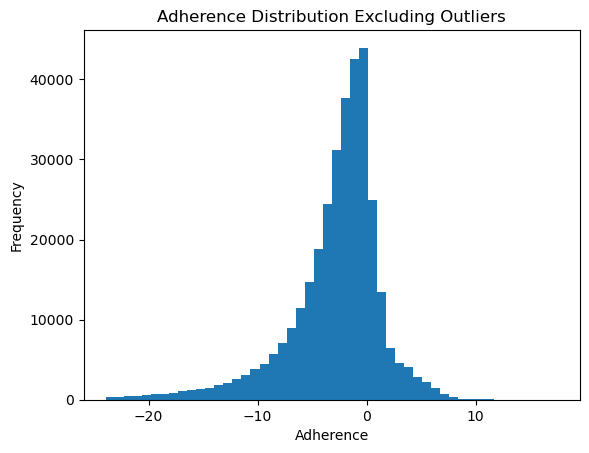

In [24]:
ax = (
    wego[wego['ADHERENCE'].between(ad_mean - ad_std*3,
                                   ad_mean + ad_std*3,
                                   inclusive='both')]
    ['ADHERENCE']
    .plot(kind='hist',
          bins=50)
)

ax.set(
    title='Adherence Distribution Excluding Outliers',
    xlabel='Adherence'
    )

In [25]:
# Calculate Headway Deviation mean and standard deviation
hd_mean = wego['HDWY_DEV'].mean()
hd_std = np.std(wego['HDWY_DEV'])

[Text(0.5, 1.0, 'Headway Deviation Distribution Excluding Outliers'),
 Text(0.5, 0, 'Headway Deviation')]

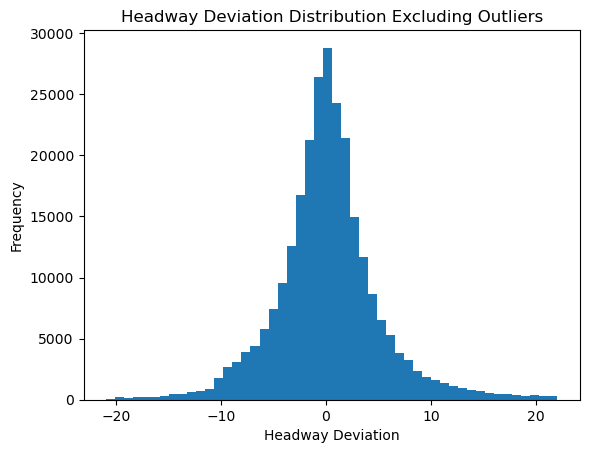

In [26]:
ax= (
    wego[wego['HDWY_DEV'].between(hd_mean - hd_std*3, 
                                  hd_mean + hd_std*3, 
                                  inclusive='both')]
    ['HDWY_DEV']
    .plot(kind='hist', bins=50)
)

ax.set(
    title='Headway Deviation Distribution Excluding Outliers',
    xlabel='Headway Deviation'
    )

# 2) How does direction of travel, route, or location affect the headway and on-time performance?

In [27]:
wego.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'DWELL_IN_MINS',
       'SCHEDULED_LAYOVER_MINUTES', 'DATE_TRIP', 'HDWY_DEV_PCT',
       'HDWY_BUNCHING', 'HDWY_AS_SCHEDULED', 'HDWY_GAPPING', 'HDWY_IDEAL',
       'HDWY_ACCEPTABLE', 'HDWY_NOT_ACCEPTABLE'],
      dtype='object')

### Route Direction

#### Headway

In [117]:
# Create new df for Headway columns grouped by Route Direction
route_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_IDEAL', 'HDWY_ACCEPTABLE', 'HDWY_NOT_ACCEPTABLE']]
         .sum()
)

In [118]:
# Create new total column for each row
route_direction_totals['TOTALS'] = route_direction_totals.sum(axis=1)

In [122]:
# Create new percentage column for each category
route_direction_totals.loc[:, 'IDEAL_PCT'] = (route_direction_totals['HDWY_IDEAL'] / 
                                                route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'ACCEPTABLE_PCT'] = (route_direction_totals['HDWY_ACCEPTABLE'] / 
                                                    route_direction_totals['TOTALS'] * 100)
route_direction_totals.loc[:, 'NOT_ACCEPTABLE_PCT'] = (route_direction_totals['HDWY_NOT_ACCEPTABLE'] / 
                                                    route_direction_totals['TOTALS'] * 100)

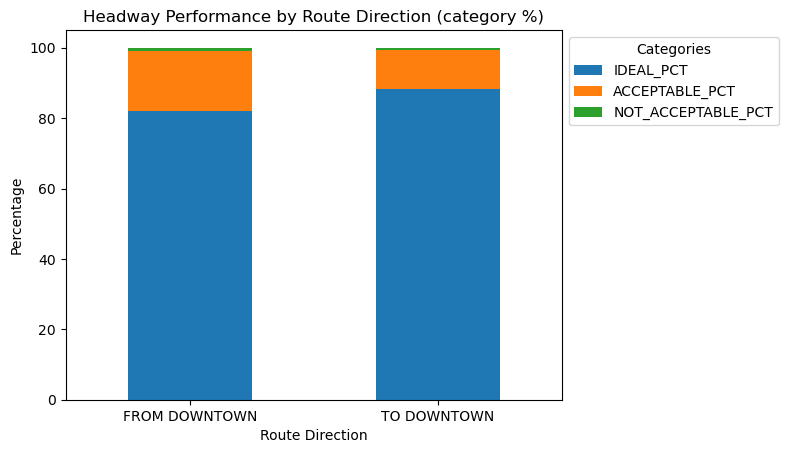

In [121]:
# Route Direction Headway Graph
ax = (route_direction_totals[['IDEAL_PCT', 'ACCEPTABLE_PCT', 'NOT_ACCEPTABLE_PCT']]
      .plot(kind='bar',
            stacked=True))

ax.set(title = 'Headway Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

#### Adherence

In [107]:
# Create new df for Headway columns grouped by Route Direction
route_ad_direction_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [113]:
# Create new total column for each row
route_ad_direction_totals['TOTALS'] = route_ad_direction_totals.sum(axis=1)

In [114]:
# Create new percentage column for each category
route_ad_direction_totals.loc[:, 'ONTIME_PCT'] = (route_ad_direction_totals['ADJUSTED_ONTIME_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'EARLY_PCT'] = (route_ad_direction_totals['ADJUSTED_EARLY_COUNT'] / 
                                                 route_ad_direction_totals['TOTALS'] * 100)
route_ad_direction_totals.loc[:, 'LATE_PCT'] = (route_ad_direction_totals['ADJUSTED_LATE_COUNT'] / 
                                                  route_ad_direction_totals['TOTALS'] * 100)

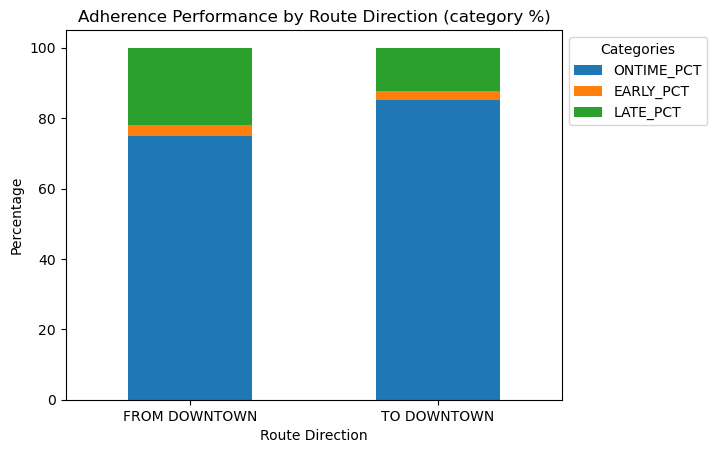

In [116]:
# Route Direction Adherence graph
ax = (
    route_ad_direction_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).plot(kind='bar', stacked=True)
ax.set(title = 'Adherence Performance by Route Direction (category %)',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(title = 'Categories', bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [45]:
wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_DEV_PCT', 'ADHERENCE']].mean()

,HDWY_DEV_PCT,ADHERENCE
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,29.216261,-3.960287
TO DOWNTOWN,22.179487,-2.321804


#### TO DOWNTOWN direction has a slightly better Headway Deviation and Adherence performance

### ROUTE Performance

In [60]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Route 22 has better overall Adherence while route 56 has better headway deviation

In [86]:
# Create new df gor Adherence columns grouped by Route
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

In [87]:
# Create new total column for each row
routes_totals['TOTALS'] = routes_totals.sum(axis=1)

In [91]:
# Create new percentage column for each category
routes_totals.loc[:, 'ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals.loc[:, 'LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

In [92]:
routes_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT,TOTALS,ONTIME_PCT,EARLY_PCT,LATE_PCT
ROUTE_ABBR,,,,,,,
3,34516,9590,1382,45488,75.879353,3.038164,21.082483
7,13417,3417,433,17267,77.703133,2.507674,19.789193
22,22492,2065,631,25188,89.296490,2.505161,8.198348
23,35137,3230,1286,39653,88.611202,3.243134,8.145664
50,36309,5113,1207,42629,85.174412,2.831406,11.994182
52,37736,10038,1553,49327,76.501713,3.148377,20.349910
55,42080,16748,1531,60359,69.716198,2.536490,27.747312
56,48361,8837,1752,58950,82.037320,2.972010,14.990670


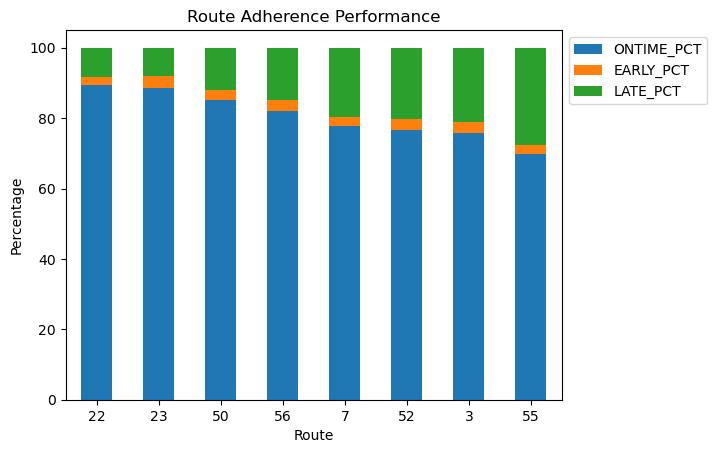

In [94]:
# Route Adherence graph
ax = (routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [ ]:
wego.groupby('BLOCK_ABBR')[['ADHERENCE', 'HDWY_DEV']].mean().abs().sort_values('ADHERENCE', ascending=True)

# 3) How does time of day or day of week affect headway and on-time performance?

#### Box plots?

In [ ]:
# Drop na depart times
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [ ]:
# Create depart time column
clean_dept_time['TIME'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.time)

In [ ]:
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

In [ ]:
clean_dept_time.groupby('HOUR')[['ADHERENCE', 'HDWY_DEV']].mean()

In [ ]:
# Convert depart time column to datetime
clean_dept_time['DEPART_TIME'] = ([pd.to_datetime('2000-01-01 ' + str(t), format='mixed')
                                   for t in clean_dept_time['TIME']])

In [ ]:
# Create Weekday column
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

In [ ]:
# use Grouper to group by hour
adherence_by_time = (clean_dept_time.groupby(pd.Grouper(key='DEPART_TIME',
                                             freq='1h'))
                     [['ADHERENCE', 'HDWY_DEV']]
                     .mean().reset_index())
adherence_by_time

In [ ]:
adherence_by_time['ADHERENCE'].plot(kind='hist', bins=24)

#### No trips were made during the hours of 2 and 3

In [ ]:
# use Grouper to group by hour
adherence_by_day = (clean_dept_time.groupby('WEEKDAY')
                     [['ADHERENCE', 'HDWY_DEV']]
                     .mean().reset_index())
adherence_by_day

# 4)

####